# import libraries

In [244]:
#--- system libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import pdb
import sys
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
reload(lp)

<module 'LammpsPostProcess' from 'LammpsPostProcess.py'>

# utility functions

In [239]:
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print 'column already included!'
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(title,dpi=75,bbox_inches='tight')
    plt.show()
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)


def GetSlice2d( hist, err,
         (xv, yv, zv),
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         (xv, yv),
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 

# Parameters

In [253]:
#--- comment out parameters if you pass them
#--- by arguments

#--- timestep
#itime = 500000*4
dlgr0 = 2.5 #--- 1st peak  in g(r)
dlgr = 4.0*1 #--- 2nd peak in g(r)
cutoff = 10.0*4    #--- cut-off radius for g(r)
NMAX = 10000*5    #--- max. number of atoms included for the g(r) analysis

ShuffleDisp = False
CrltnFunctionUnstructured = False
PairCorrelationFunction = False

#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/BmgData'

#--- stress files
fileNamee = ('FeNi.txt', 
             'CoNiCr.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'Co5Cr2Fe40Mn27Ni26.txt')[0]

#--- dump files
fileName = '%s/%s'%(path,['FeNi_glass.dump',
            'CoNiCr_glass.dump',
            'CoNiCrFe_glass.dump',
            'CoCrFeMn_glass.dump',
            'Co5Cr2Fe40Mn27Ni26_glass.dump'][0])#--- parse cords



# input stress file

In [3]:
# stress = np.loadtxt('%s/%s'%(path,fileNamee) )

## Dump File

In [245]:
#--- parse lammps data
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxint, columns = {'c_mystress[4]':'sxy'} )

# stress-strain curve

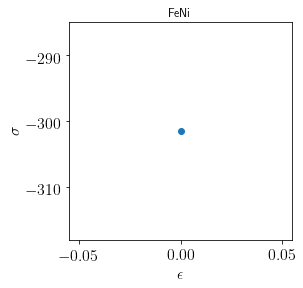

In [252]:

fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(fileNamee[:-4])
#
# ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
strain = []
Virial = []
times = lmpData.coord_atoms_broken.keys()
times.sort()
for itimee in times:

    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    #
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] ) #--- reference state
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- volume
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    
    #--- virial stress
    virial = np.sum(atoms.sxy) / volume

    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1    
    
    #--- append
    strain += [ebulk]
    Virial += [virial] #*1e-4] 
#
ax.plot(np.array(strain), Virial, '-o')
#
plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
plt.show()
#
#np.savetxt('4.txt',np.c_[2*np.array(strain), Virial])

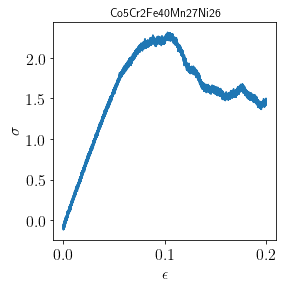

In [395]:
# def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
#     [xlo,xhi,ylo,yhi] = ax.axis()
#     if LOG_X:
#         [xlo,xhi,junk,junk] = np.log10(ax.axis())
#     if LOG_Y:
#         [junk,junk,ylo,yhi] = np.log10(ax.axis())
#     lx = xhi - xlo
#     ly = yhi - ylo
#     xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
#     height = ly*(1+alpha_yb+alpha_yt)
#     width = lx*(1+alpha_xl+alpha_xr)
#     xy_end=[xy[0]+width,xy[1]+height]
#     if LOG_X:
#         xy[0] = 10 ** xy[0]
#         xy_end[0] = 10 ** xy_end[0]
#     if LOG_Y:
#         xy[1] = 10 ** xy[1]
#         xy_end[1] = 10 ** xy_end[1]
#     ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
#                                     height=xy_end[1]-xy[1], linewidth=linewidth,
#                                     clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
    
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# ax.set_xlabel(r'$\epsilon$',fontsize=16)
# ax.set_ylabel(r'$\sigma$',fontsize=16)
# ax.tick_params(labelsize=16)
# ax.set_title(fileNamee[:-4])
# #
# ax.plot(stress[:,0],stress[:,1],'-')

# #--- point corresponding to strain maps
# ADD_POINTS = False
# strain = []
# Virial = []
# if ADD_POINTS:
#     for itime in coord_atoms_broken:
#         CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
#         volume = np.linalg.det( CellVectorOrtho )
#         virial = np.c_[coord_atoms_broken[itime]['c_mystress4']].astype(float).sum() / volume
#         #--- strain
#         dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#         l1=CellVector[ itime ][1,1]
#         strain += [0.5*dx/l1]
#         Virial += [virial*1e-4] 
#     #
#     ax.plot(2*np.array(strain), Virial, 'x',color='red')
# #
# plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
# plt.show()
# #
# np.savetxt('4.txt',np.c_[2*np.array(strain), Virial])

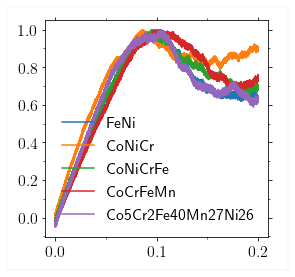

In [4]:
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# # ax.set_xlabel(r'$\epsilon$',fontsize=20)
# # ax.set_ylabel(r'$\sigma/\sigma_y$',fontsize=20)
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
# #ax.set_title(fileNamee[:-4])
# #
# FileNamee = ('FeNi.txt', 
#              'CoNiCr.txt', 
#              'CoNiCrFe.txt',
#              'CoCrFeMn.txt',
#              'Co5Cr2Fe40Mn27Ni26.txt')
# #FileNamee = ['CoNiCrFe.txt']
# #
# for fileNamee in FileNamee:
#     stress = np.loadtxt('%s/%s'%(path,fileNamee) )
#     #
#     ax.plot(stress[:,0],stress[:,1]/stress[:,1].max(),'-', label = fileNamee[:-4])
# ax.legend(frameon=False, fontsize=16)
# #
# DrawFrame(ax, (0.17,0.09),(0.15,0.06),0.04)
# #
# plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight')
# plt.show()

# Plastic Deformation


## Compute Displacements


In [227]:

#--- extract atom and box properties
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#
box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
  
#--- wrap coordinates
wrap = lp.Wrap( atoms, box )
wrap.WrapCoord()
wrap.Set( atoms ) #--- atoms: set wrapped xyz     

#--- print actual xyz
# PrintOvito( pd.DataFrame(atoms.__dict__), 
#              open( 'xyz_actual.xyz','w'), 
#              footer = 'ITIME=%s'%itime,
#              attr_list=['id','type','x','y','z'])

#--- map to square box
mapp = lp.Map( atoms, box ) 
mapp.ChangeBasis()
mapp.Set( atoms ) #--- atoms: add mapped xyz

#--- print mapped xyz
# PrintOvito( pd.DataFrame(atoms.__dict__), 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','xm','ym','zm'] )

#--- include copies
copy = lp.Copy( atoms, box )
copy.FullCopies()
xatoms = copy.Get()

#--- print mapped xyz
# PrintOvito( pd.DataFrame(xatoms.__dict__), 
#             open( 'xyz_full.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','xm','ym','zm'] )

#--- compute displacements
#--- need attributes for the reference state
atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
wrap = lp.Wrap( atoms0, box0 )
wrap.WrapCoord()
wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
mapp = lp.Map( atoms0, box0 ) 
mapp.ChangeBasis()
mapp.Set( atoms0 ) #--- atoms: add mapped xyz
copy = lp.Copy( atoms0, box0 )
copy.FullCopies()
xatoms0 = copy.Get()
#
cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
cdisp.SetWrapped() 
uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
#
pd.DataFrame(uatoms.__dict__).head()

BoxBounds.shape=3,3 is not (3,3)!
add [0. 0. 0.]!


,dx,dy,dz,id,type,x,xm,y,ym,z,zm
0,-1.08064,-0.13560,0.0594,1.0,4.0,4.73092,4.73092,-20.57810,-20.57810,-41.4164,-41.4164
1,-0.85123,0.01500,-0.2206,2.0,2.0,-5.47277,-5.47277,-15.50650,-15.50650,-11.9452,-11.9452
2,1.46670,-0.17600,0.0813,3.0,2.0,-35.09840,-35.09840,26.30910,26.30910,27.5002,27.5002
3,0.05390,0.16193,-0.1989,4.0,2.0,-35.96470,-35.96470,-2.19362,-2.19362,-39.5794,-39.5794
4,-1.57800,-0.03190,0.1683,5.0,2.0,30.55360,30.55360,-33.67560,-33.67560,-25.6883,-25.6883


In [68]:
# #--- shuffle displacements
if ShuffleDisp:
    xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
    np.random.shuffle(xrand)
    junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
           uatoms.zm]
    cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
    #np.c_[junk,xrand]
    uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

### Print

In [225]:
#--- get a chunk
cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                  epsilon = 0.0, mode = 'isotropic' )


PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
            open( 'xyz_expanded.xyz','w'), 
            footer = 'ITIME=%s'%itime,
            attr_list=['id','type','x','y','z','dx','dy','dz'] )

## D2min

### Compute pair correlation function

In [65]:
if PairCorrelationFunction:
    rdf = lp.ComputeRdf(  atoms, box, 
                       cutoff = cutoff, NMAX = NMAX)

    rdf.Distance(WRAP = True)
    rdf.PairCrltn( nbins = 32 )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    plt.show()

### partition the space, make fits, and compute squared errors 

In [228]:
#--- Create "Atoms" object with dx,x attributes and
#--- atoms within the original box
cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                  epsilon = 0.0, mode = 'isotropic' )
#--- filter the full copy
atomd = lp.Atoms(**pd.DataFrame(uatoms.__dict__)[indices].to_dict(orient='list'))
#
d2min = lp.ComputeD2min(atomd, box0, dlgr)
d2min.Partition()
d2min.D2min()
d2min = d2min.Get(attrs=['id','type','x','y','z','xm','ym','zm','d2min'])
#
pd.DataFrame(d2min.__dict__).head()

,d2min,id,type,x,xm,y,ym,z,zm
0,0.174117,1588.0,2.0,-36.5156,-36.5156,-41.7659,-41.7659,-37.4528,-37.4528
1,0.052150,2517.0,4.0,-32.2449,-32.2449,-38.2246,-38.2246,-42.1487,-42.1487
2,0.083888,2741.0,4.0,-32.1688,-32.1688,-37.4879,-37.4879,-37.9695,-37.9695
3,0.208109,2800.0,4.0,-34.8963,-34.8963,-35.9155,-35.9155,-37.7770,-37.7770
4,0.011530,3610.0,4.0,-35.6839,-35.6839,-39.7431,-39.7431,-36.2111,-36.2111


### Print

In [232]:
#--- print 
file_name = 'd2min.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass


# times = dfD2min.keys()
# times.sort()
# for itime in dfD2min:
PrintOvito( pd.DataFrame(d2min.__dict__), 
            open(file_name,'a'), 
            footer = 'ITIME=%s'%itime,
            attr_list=['id','type','xm','ym','zm','d2min'] )


### Interpolate

In [233]:
#--- mean dist between atoms 
natoms = len( atoms0.x ) 
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 


#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                 box0.CellVector, 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#--- expand the original box
cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
cptmp.Expand( epsilon = 0.1, mode = 'isotropic' )
d2exp = cptmp.Get()

points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
values = np.c_[d2exp.d2min] #--- corresponding values

grid_z = scp_int.griddata(points, values, xi, method='linear')
assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

#--- make an object
d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))



#### Imshow

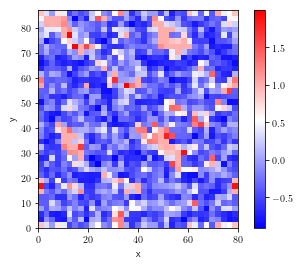

In [234]:
#--- reshape value
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
#--- xy plane
val = value[:,:,-1].copy()

PltBitmap(val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = True,
          frac = 1.0, #--- plot a patch
          title = 'd2min.png',
        )

### Crltn Function (Unstructured points)

In [222]:
if CrltnFunctionUnstructured:
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

--Return--
> /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/LammpsPostProcess.py(685)AutoCrltn()->None
-> pdb.set_trace()


KeyboardInterrupt: 

In [202]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

#### Plot Crltns

In [203]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

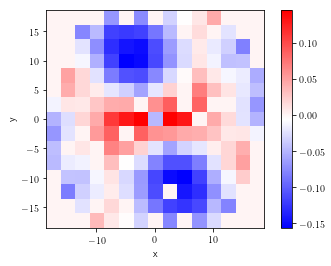

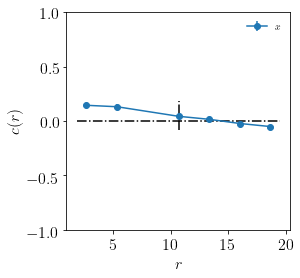

10.699313962120927

In [219]:
if CrltnFunctionUnstructured:
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           (xvv, yvv, zvv),
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 (xv2d, yv2d),
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

### Crltn Function (FFT)

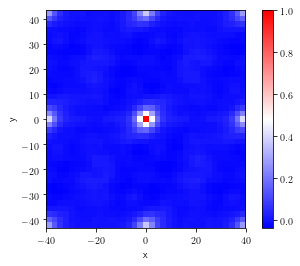

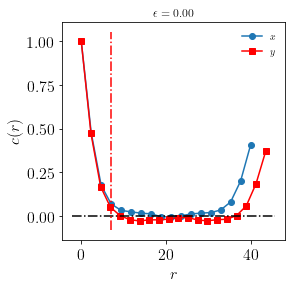

In [259]:
(nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
#
value = np.c_[d2intrp.d2min].reshape((ny,nx,nz))
        
#--- shuffle
#     ( nx, ny, nz ) =  value.shape
#     slist = value.flatten()
#     np.random.shuffle(slist)
#     value=slist.reshape((nx, ny, nz))    
#
#--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )

crltn = GetAutoCorrelation( value )

    
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
#    

#--- xy plane
val = crltn[:,:,0].copy()
PltCrltn( val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
          frac = 1, #--- plot a patch
          zscore = False,
          fileName = 'cxy_d2min.%s.png'%itime,
          dpi = 60
        )

#--- bulk strain
dx=box.CellVector[0,1]-box0.CellVector[0,1]
l1=box.CellVector[1,1]
ebulk = dx/l1
#---
xc, yc = PltCrltnFunc(   crltn, 
                         (xv,yv),
                         fileName = 'cr_d2min.%s.png'%itime,
                         title = r'$\epsilon=%3.2f$'%(2*ebulk),
                         cTOL = 8.0e-2,
            #             dpi = 60,
                        )
#--- save
np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')

#### Multiple Times

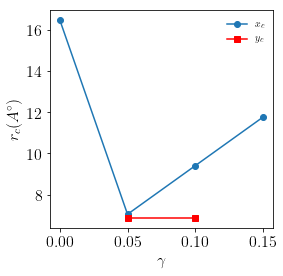

In [298]:
try:
    i=0
    append = False
    while True:
        sarr0 = np.c_[np.loadtxt('glassFeNi%i/Run0/rc_d2min.txt'%i)].T
#        print i,sarr0
        if not append:
            sarr = sarr0.copy()
            append = True
        else:
            sarr = np.concatenate((sarr,sarr0),axis=0)
        i+=1
except:
    pass

#--- plot
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
xstr = r'$\gamma$'
ystr = r'$r_c(A^\circ)$'
ax.set_xlabel(xstr,fontsize=16)
ax.set_ylabel(ystr,fontsize=16)
ax.tick_params(labelsize=16)
#
ax.plot( sarr[:,0], sarr[:,1],'-o', color='C0', label = r'$x_c$')
ax.plot( sarr[:,0], sarr[:,2],'-s', color='red', label = r'$y_c$')
ax.legend(frameon=False)
plt.savefig('rc.png',dpi=75,bbox_inches='tight')
plt.show()


## Displacement Gradients

### Interpolate Displacements
#### cubic grid

In [91]:
#--- mean dist between atoms 
natoms = len( atoms0.x ) 
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                 box0.CellVector, 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


#### center box + margin

In [92]:
#--- get a chunk of the full copy
cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                  epsilon = 0.2, mode = 'isotropic' )

points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

grid_z = scp_int.griddata(points, values, xi, method='linear')
assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

#--- make an object
uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



#### Print

In [289]:
file_name = 'uintrp.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass

#for itime in df_intrp:
PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                open( file_name,'a'), 
                footer = 'ITIME=%s'%itime,
                attr_list=['x','y','z','dx','dy','dz'] )


### Strain tensor

In [93]:
csn = lp.ComputeStrn( uintrp, box0 )
csn.Reshape( (xlin, ylin, zlin) )
csn.Gradient()
csn.SetStrn('exy')
Exy = csn.Get(attrs = ['x','y','z','exy'])


#### imshow

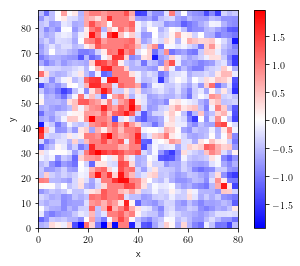

In [96]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf




#itime = np.max(dfD2min_intrp.keys())
#--- reshape value
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
#value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

# lx=xlin[-1]-xlin[0]
# ly=ylin[-1]-ylin[0]
# #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
# value = np.c_[df_intrp[itime]['ux']]
# value = value.reshape(((ny,nx,nz)))
#print value.shape

#--- filter value
# value = FilterMatrix( box0.CellVector, box0.CellOrigin,
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )
#print value.shape
#print vf.shape

CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
#--- xy plane
val = value[:,:,-1].copy()
#val = value[:,:,nz/2].copy()
#print val.shape

PltBitmap(val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = True,
          frac = 1.0, #--- plot a patch
           title = 'strain.png',
       )

In [89]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [90]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

#### Print

In [30]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
# times = Strain.keys()
# times.sort()
#--- bulk strain
dx=box.CellVector[0,1]-box.CellVector[0,1]
l1=box.CellVector[1,1]
ebulk = 0.5*dx/l1


PrintOvito( pd.DataFrame(Exy.__dict__), 
                open( file_name,'a'), 
                footer = 'epsilon=%2.1e'%(2*ebulk),
                attr_list=['x','y','z','exy'] )
    

#### Auto-Correlations

In [97]:
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real


#Crltn = {}
(nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
#
value = np.c_[Exy.exy].reshape((ny,nx,nz))
#    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
#    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
        
#--- shuffle
#     ( nx, ny, nz ) =  value.shape
#     slist = value.flatten()
#     np.random.shuffle(slist)
#     value=slist.reshape((nx, ny, nz))    
    #
#--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )

Crltn = GetAutoCorrelation( value )


#### Print

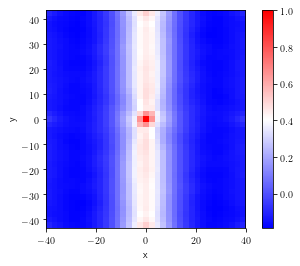

In [99]:
# for itime in Crltn:
#     print 'itime=',itime
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #    
crltn = Crltn #[ itime ]
#--- xy plane
val = crltn[:,:,0].copy()
PltCrltn( val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
          frac = 1, #--- plot a patch
          zscore = False,
          fileName = 'cxy_strain.%s.png'%itime,
          dpi = 60
        )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



#### Crltn Length

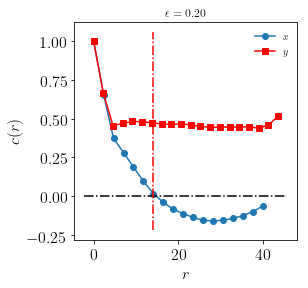

(14.108201970564707, nan)

In [107]:
# for itime in Crltn:
#     print 'itime=',itime
#--- bulk strain
dx=box.CellVector[0,1]-box0.CellVector[0,1]
l1=box.CellVector[1,1]
ebulk = 0.5*dx/l1
#---
PltCrltnFunc( Crltn, 
             (xv,yv),
             fileName = 'cr_strain.%s.png'%itime,
             title = r'$\epsilon=%3.2f$'%(2*ebulk),
             cTOL = 8.0e-2,
             dpi = 60,
            )

In [109]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()
